# Expression analysis in TCGA DATA with AnnData

This notebook will demonstrate how to analyze TCGA data in the AnnData form.

## Load data

In [ ]:
import anndata as ad
import hvplot.pandas  # noqa
import numpy as np
import pydeseq2.dds
import pydeseq2.ds

exp = ad.read_h5ad("/Users/cvaske/Downloads/brca_test.h5ad")

# Select a cohort

In [ ]:
exp.obs.sample_type_name.value_counts()

In [ ]:
sample_types = ["Primary Tumor", "Solid Tissue Normal"]

In [ ]:
exp.obs.primary_site.value_counts()

In [ ]:
brca = exp[(exp.obs.primary_site == "Breast") & (exp.obs.sample_type_name.isin(sample_types))]
brca = brca[:, np.mean(brca.X, axis=0) > 50].copy()
brca.X = brca.X.todense()

In [ ]:
brca_ds = pydeseq2.dds.DeseqDataSet(adata = brca, design="~sample_type_name")
brca_ds.deseq2()

In [ ]:
brca_ds.layers['log1p'] = np.log1p(brca_ds.layers['normed_counts'])

In [ ]:
t_n = pydeseq2.ds.DeseqStats(brca_ds, contrast=["sample_type_name"] + sample_types)
t_n.summary()

In [ ]:
y

In [ ]:
t_n_res = t_n.results_df

In [ ]:
t_n_res

In [ ]:
t_n_res['neg_log10_p'] = -np.log10(t_n_res['pvalue'])
t_n_res['neg_log10_padj'] = -np.log10(t_n_res['padj'])
t_n_res.hvplot.scatter(x="log2FoldChange", y="neg_log10_padj")

# TODO: add vertical and horizontal lines to correspond to cutoffs of padj < 0.05, log2fc >1

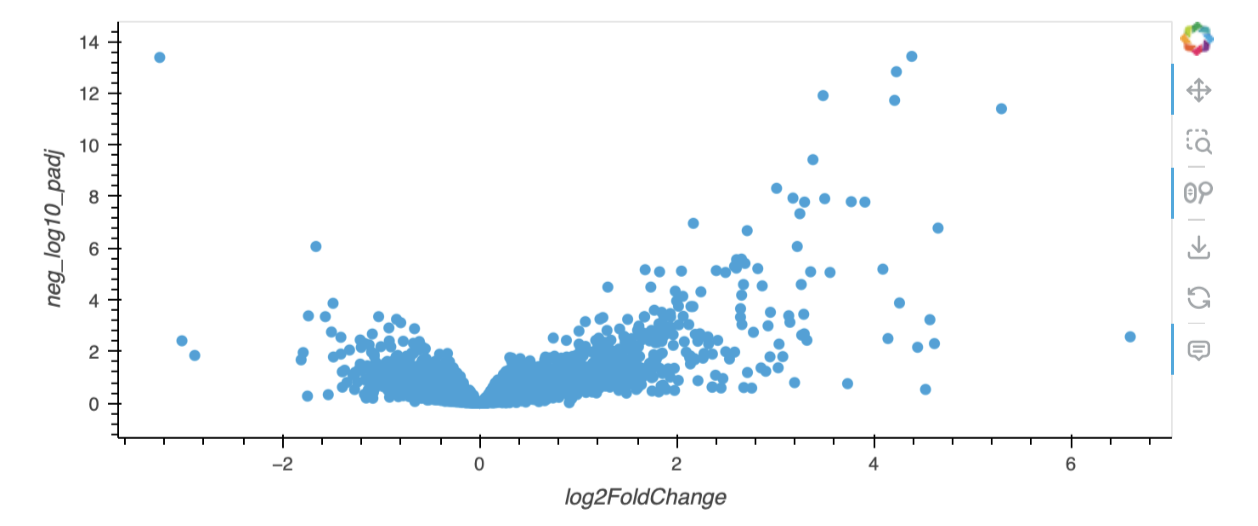

In [ ]:
sig_genes = t_n_res[(t_n_res['neg_log10_padj'] > - np.log10(0.05)) & (abs(t_n_res['log2FoldChange']) > 1.0)]
sig_genes

In [ ]:
brca_ds_sigs  = brca_ds[:, sig_genes.index]

In [ ]:
## This is what I would like to exist...
scanpy.pl.clustermap(brca_ds_sigs, layer="log1p")

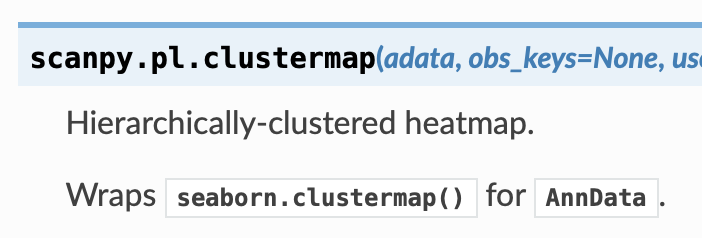

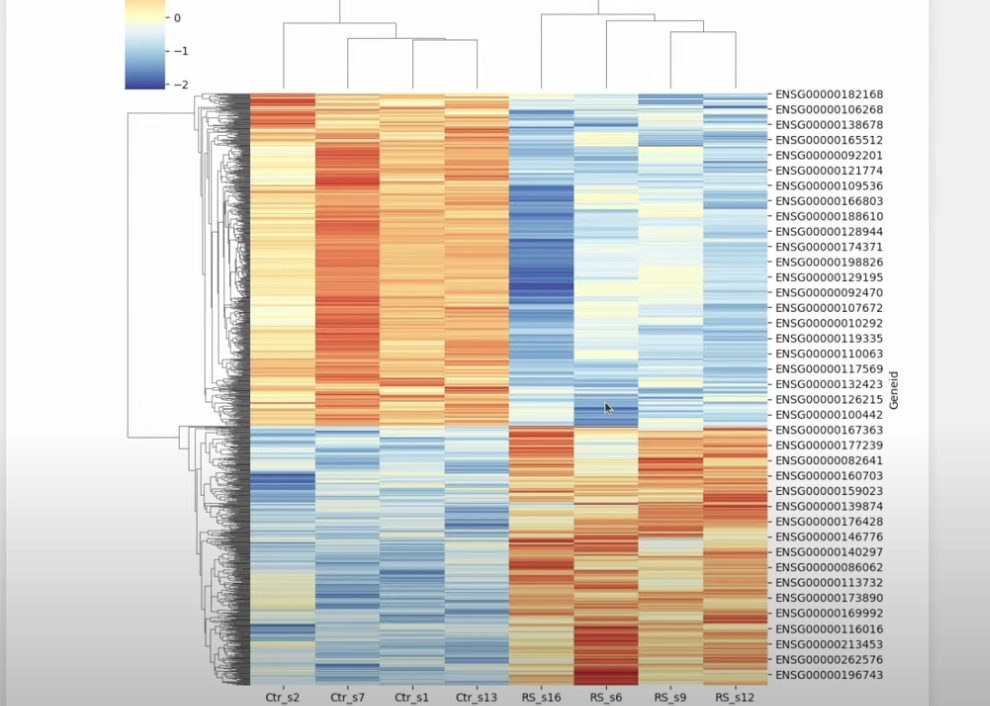

# Protein Expression Analysis

Now the we will perform the same analysis with CPTAC proteomic data.